In [41]:
# check the version of statsmodel. If you don't have the latest version 0.12.2, you may reinstall it
import statsmodels
print(print(statsmodels.__version__))

0.13.0
None


In [2]:
# you may reinstall statsmodels to get the latest version
!pip install statsmodels==0.13.0


     |████████████████████████████████| 9.8 MB 13.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
!pip install pmdarima #a statistical library for ARIMA

     |████████████████████████████████| 1.4 MB 14.2 MB/s 


In [3]:
## mount the Google drive to get access to files in your drive ##
from google.colab import drive
drive.mount('/content/drive')

## set the folder that stores your files and data as your current directory ##
%cd /content/drive/My\ Drive/Colab\ Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [4]:
## import libraries and tools ##

import numpy as np # linear algebra
import pandas as pd # data processing and CSV file I/O 

import seaborn as sns

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import missingno  # missing data visualization

import scipy as sp
#from scipy import stats


# TIME SERIES
from statsmodels.tsa.arima.model import ARIMA # v 0.13.0
#from statsmodels.tsa.arima_model import ARIMA #v 0.12.1
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf,arma_order_select_ic
import statsmodels.stats.diagnostic as smd
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [5]:
df_train=pd.read_excel( 'Data/DailyDelhiClimateTrain.xlsx' )
df_valid=pd.read_excel( 'Data/DailyDelhiClimateTest.xlsx' )


In [6]:
# define the univariate dataframe for study
train=df_train[[ 'date' , 'wind_speed' ]].copy()
train.columns=[ 'ds' , 'y' ]


In [7]:
test=df_valid[[ 'date' , 'wind_speed' ]].copy()
test.columns=[ 'ds' , 'y' ]

In [8]:
x_train = pd.DataFrame(train[ 'ds' ])
y_train = pd.DataFrame(train[ 'y' ])
x_valid = pd.DataFrame(test[ 'ds' ])
y_valid = pd.DataFrame(test[ 'y' ])

In [9]:
# we need to change the string format of 'date' to timedate
from datetime import datetime, date 

x_train['ds'] = pd.to_datetime(x_train['ds'], format = '%d/%m/%Y')
x_valid['ds'] = pd.to_datetime(x_valid['ds'], format = '%d/%m/%Y')

In [11]:
x_train.describe

<bound method NDFrame.describe of              ds
0    2013-01-01
1    2013-01-02
2    2013-01-03
3    2013-01-04
4    2013-01-05
...         ...
1457 2016-12-28
1458 2016-12-29
1459 2016-12-30
1460 2016-12-31
1461 2017-01-01

[1462 rows x 1 columns]>

In [13]:
x_valid.describe

<bound method NDFrame.describe of             ds
0   2017-01-01
1   2017-01-02
2   2017-01-03
3   2017-01-04
4   2017-01-05
..         ...
109 2017-04-20
110 2017-04-21
111 2017-04-22
112 2017-04-23
113 2017-04-24

[114 rows x 1 columns]>

Question 1: so the time frame for train data set is from 2013-01-01 to 2017-01-01
and the time frame for test data is 2017-01-01 to 2017-04-24

In [14]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (4,2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0),colspan=2)
        pacf_ax = plt.subplot2grid(layout, (2,0),colspan=2)
        qq_ax = plt.subplot2grid(layout, (3, 0))
        pp_ax = plt.subplot2grid(layout, (3, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


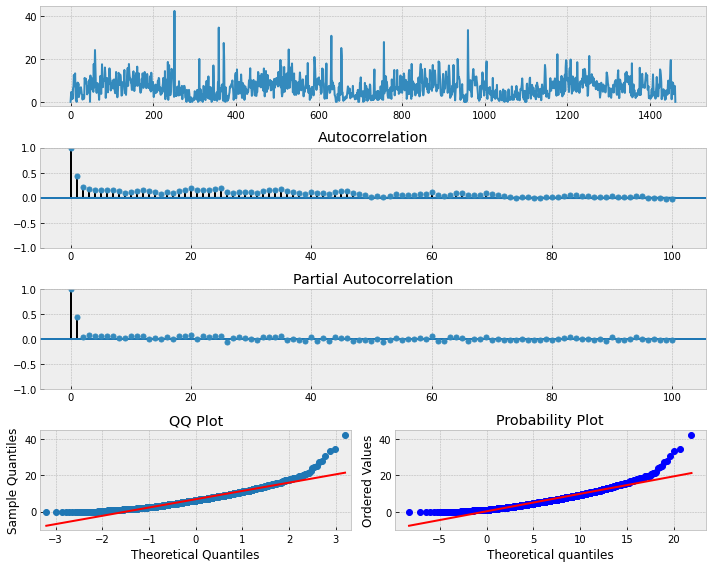

In [15]:
tsplot(y_train['y'],lags=100)

(734869.0, 736330.0)

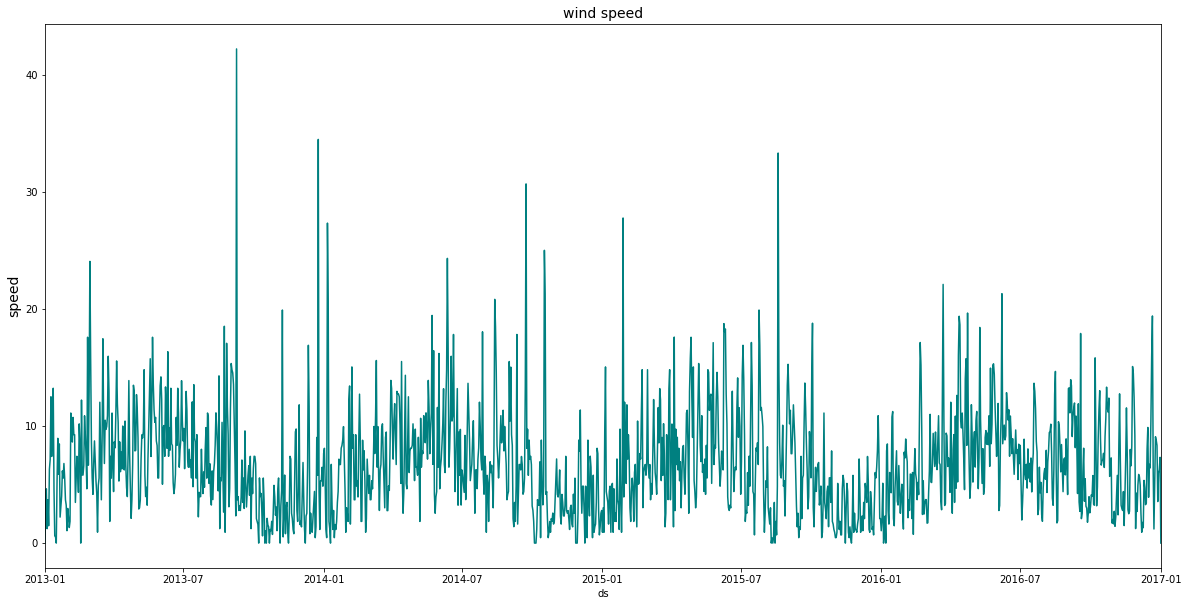

In [17]:
# Take a look at the time series 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, color='teal')
ax.set_title('wind speed', fontsize=14)
ax.set_ylabel('speed', fontsize=14)
                      
ax.set_xlim([date(2013, 1, 1), date(2017, 1, 1)])

observation:the wind speed seem to be below 20 for most cases and fluctuate mainly in the 0-10 range.Also, there seems to be a seasonality trend every year. 

### **3) Explatory Analysis**

### 1)seasonality

In [23]:
# use seasonal_decompose function to perform decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(y_train['y'], period=365, model='additive', extrapolate_trend='freq') # if you use statsmodels version 0.13.1
y_train["y_seasonal"] = decomp.seasonal

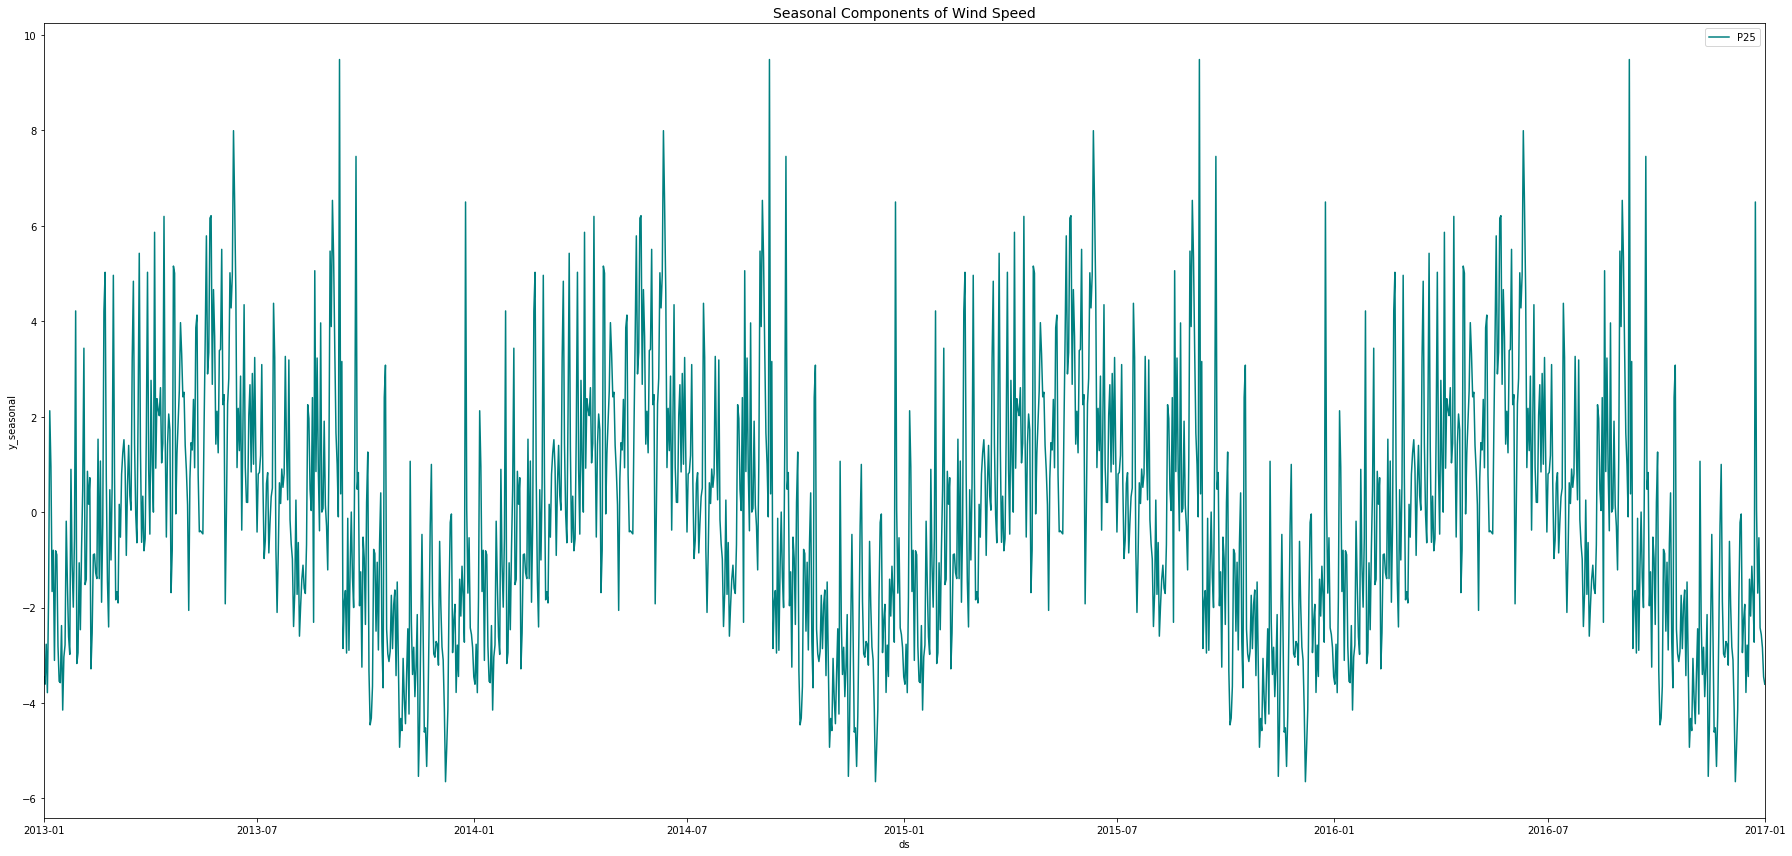

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 12))
ax.set_title('Seasonal Components of Wind Speed', fontsize=14)


sns.lineplot(x=x_train['ds'], y=y_train['y_seasonal'], ax=ax, color='teal', label='P25')
#ax.set_ylabel(ylabel=column, fontsize=12)
ax.set_xlim([date(2013, 1, 1), date(2017, 1, 1)])
    
plt.tight_layout()
plt.show()

I notice seasonality patterns every year. Also for the fisrt six month of every year the wind speed will increase and in the last six month of year the wind speed will decrease.

From the auto correlation plot, we can see that the values converge to zero, soo the time series is auto correlated.

In [38]:
# augmented Dickey-Fuller test
def adf_test(series, **kw):    
    adf_statistic, p_value, lag, nobs, critical_values, levels = adfuller( series, **kw)
    # Format Output
    print(f'adf statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {lag}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"stationary " if p_value < 0.05 else "not stationary"}')

adf_test(y_train['y'])

adf statistic: -3.8380967566850988
p-value: 0.0025407221531464543
num lags: 24
Critial Values:
   1% : -3.434908816804013
   5% : -2.863553406963303
   10% : -2.5678419239852994
Result: The series is stationary 


In [39]:
# KPSS test
def kpss_test(series, **kw):    
    kpss_stistic, p_value, lag, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS statistic: {kpss_stistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {lag}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not stationary" if p_value < 0.05 else "stationary"}')

kpss_test(y_train['y'])

KPSS statistic: 0.13773363518932502
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2003: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Text(0, 0.5, 'wind_speed')

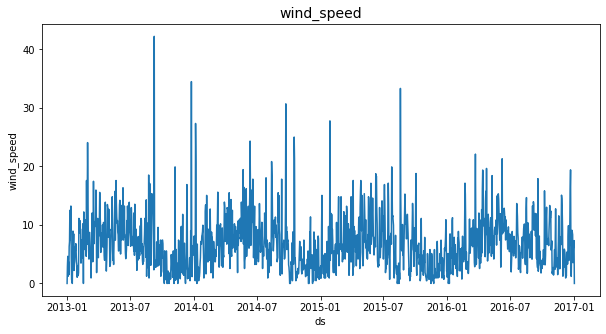

In [49]:
fig, ax=plt.subplots(nrows=1,ncols=1,figsize=(10,5))
sns.lineplot(x=x_train['ds'],y=y_train['y'],ax=ax)
ax.set_title("wind_speed",fontsize=14)
ax.set_ylabel('wind_speed')

### based on the test result our data is stationary.there is a seasonality pattern 

### **4)Predictice Model**

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet(daily_seasonality=True)
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat']) 
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

print('MAE: {}'.format(score_mae))

RMSE: 3.5016604957668753
MAE: 2.806756410285233


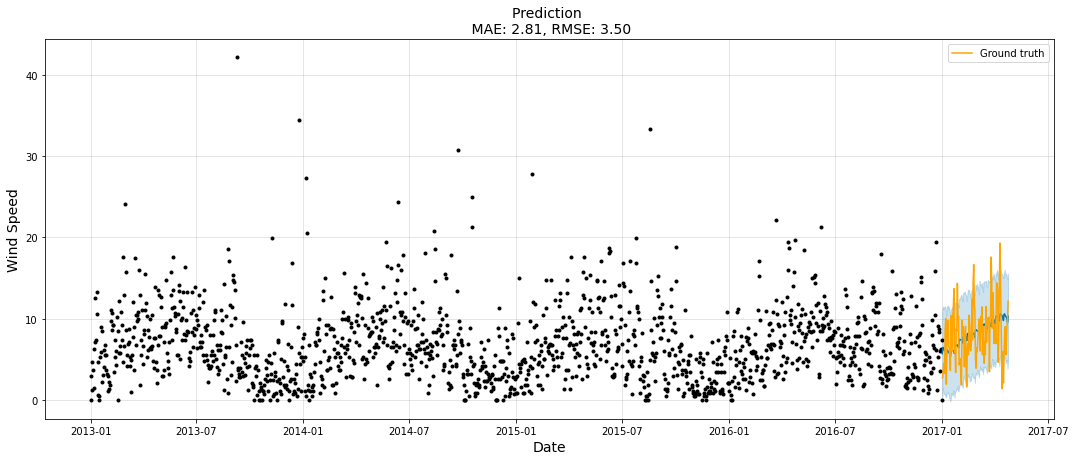

In [28]:
# Plot the forecast
fig, ax = plt.subplots(1,figsize=(15,6))


model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Wind Speed', fontsize=14)

plt.show()

### section 5)

In [31]:
y_pred.iloc[59]

ds                            2017-03-01 00:00:00
trend                                     2.52536
yhat_lower                                3.08971
yhat_upper                                13.5596
trend_lower                               2.51655
trend_upper                               2.53323
additive_terms                            6.01538
additive_terms_lower                      6.01538
additive_terms_upper                      6.01538
daily                                     5.57329
daily_lower                               5.57329
daily_upper                               5.57329
weekly                                   0.128325
weekly_lower                             0.128325
weekly_upper                             0.128325
yearly                                   0.313774
yearly_lower                             0.313774
yearly_upper                             0.313774
multiplicative_terms                            0
multiplicative_terms_lower                      0


The prediction is 8.54075 and the confidence interval is (3.08971,13.5596)

## Bonous Questiom

In [35]:
decomp = seasonal_decompose(y_pred['yhat'], period=30, model='additive', extrapolate_trend='freq') # if you use statsmodels version 0.13.1
y_pred["yhat_trend"] = decomp.trend
y_pred["yhat_seasonal"] = decomp.seasonal

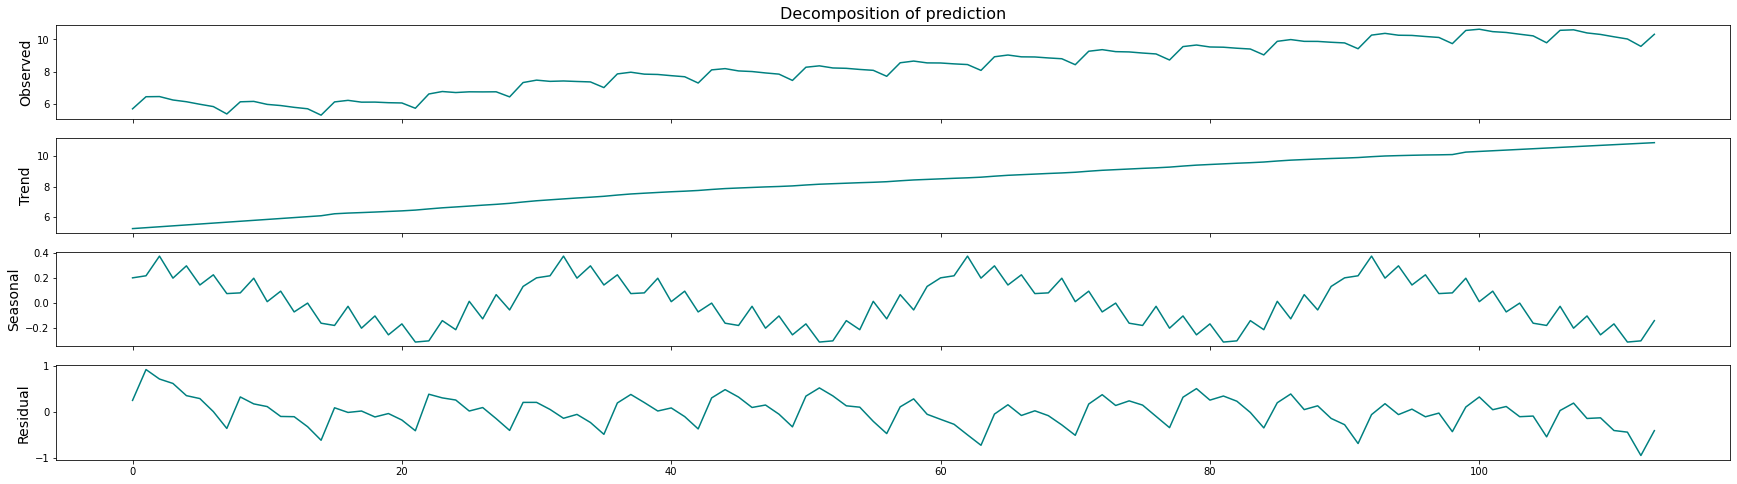

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(30,8))



res = seasonal_decompose(y_pred['yhat'], period=30, model='additive', extrapolate_trend='freq') # if you use statsmodels version 0.13.1

ax[0].set_title('Decomposition of prediction', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='teal')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='teal')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='teal')
ax[2].set_ylabel('Seasonal', fontsize=14)
    
res.resid.plot(ax=ax[3], legend=False, color='teal')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()